In [18]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = Path().resolve()
path_data = path / "data"

In [135]:
df_nhanes = pd.read_csv(str(path_data) + "/step_02_00_all_data.csv")
print(f"Start QC Process with: {len(df_nhanes)} records")

/var/folders/06/f05rc_9x21nfs2142bf0fmcr0000gn/T/ipykernel_46593/2230606715.py:1: DtypeWarning: Columns (442,869) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nhanes = pd.read_csv(str(path_data) + "/step_02_00_all_data.csv")


Start QC Process with: 396943 records


In [137]:
# Slip data into two groups (age < 18 and age >= 18)
# Many records do not have age information, so we will drop them (sequence > 0)
df_nhanes_lt = df_nhanes.loc[df_nhanes["RIDAGEYR"] < 18]
df_nhanes_gt = df_nhanes.loc[df_nhanes["RIDAGEYR"] >= 18]

print(f'< 18: {len(df_nhanes_lt)}')
print(f'>= 18: {len(df_nhanes_gt)}')
print(f'Total: {len(df_nhanes_lt)+len(df_nhanes_gt)}')

< 18: 42112
>= 18: 59204
Total: 101316


In [139]:
# Drop rows with missing values in the cofounders
# RIAGENDR,Gender
# RIDAGEYR,Age in years at screening
# BMXBMI,Body Mass Index (kg/m**2)
# RIDRETH1,Race/Ethnicity - Recode
# Cycle (All records have a cycle number)

columns_to_check = ['RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'BMXBMI']
df_nhanes_gt = df_nhanes_gt.dropna(subset=columns_to_check)
print(f"After drop NA in Age, Gender, BMI and Race/Ethnicity: {len(df_nhanes_gt)} records")

After drop NA in Age, Gender, BMI and Race/Ethnicity: 55206 records


In [ ]:
# Set the cycle column to a categorical variable and order it
cycle_order = [
    '1999-2000',
    '2001-2002',
    '2003-2004',
    '2005-2006',
    '2007-2008',
    '2009-2010',
    '2011-2012',
    '2013-2014',
    '2015-2016',
    '2017-2018'
]
df_nhanes_gt['Cycle'] = pd.Categorical(df_nhanes_gt['Cycle'], categories=cycle_order, ordered=True)

## Cofounders

### Age
RIDAGEYR: Age in years, at the time of the screening interview, is reported for survey participants between the ages of 1 and 79 years of age. All responses of age 80 years and older are coded as ‘80’. The reporting of age in single years for adults 80 years and older was determined to be a disclosure risk. In NHANES 2007-2008, the weighted mean age for participants 80 years and older is 85 years.  Each respondent’s actual or imputed date of birth was used to calculate RIDAGEYR. The procedure that NCHS used to impute age at screener, when the date of birth is missing or refused but the respondent’s age in years is provided, is as follows: If month of birth is missing or not given, it is imputed as 7. If day of birth is missing or not given, it is imputed as 1. If the year of birth is missing or not given, it is imputed as the year of the screening interview minus the age in years provided by the respondent during the screening interview. Corrections are made to this imputed information for respondents who are less than 1 year of age at the time of screening"

RIDAGEYR: This is the age of the sample person at the time of the screening interview. Age in years is reported by single year of age for persons from 1 through 84 years of age. For older adults, age in years was top coded at 85 years to reduce the risk of disclosure. All adults 85 years and older have a RIDAGEYR value of ’85’. In NHANES 2003-2004, the weighted mean age for participants 85 years and older is 88 years.
If exact date of birth information is provided during the interview, this information is used to calculate the exact age on the date of screening. Otherwise, an imputed date of birth is created using the following procedures: When date of birth information is missing or refused, but age in years is provided by the sample person: If month of birth is missing or not given it is imputed as 7. If day of birth is missing or not given, it is imputed as 1. If year of birth is missing or not given, it is imputed as the year of the screening interview less the age in years provided by the sample person at screening. Corrections are made to this imputed information for sample persons who are less than 1 year of age at the time of screening.

Age distribution
count    55206.000000
mean        47.264808
std         19.203340
min         18.000000
25%         30.000000
50%         46.000000
75%         63.000000
max         85.000000
Name: RIDAGEYR, dtype: float64


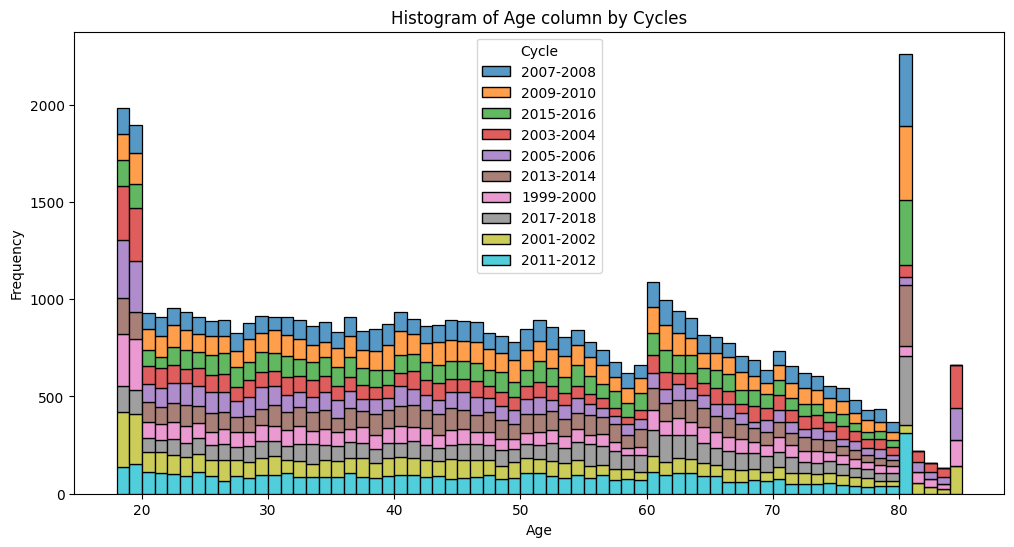

In [140]:
print("Age distribution")
print(df_nhanes_gt["RIDAGEYR"].describe())

# Age distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df_nhanes_gt, x='RIDAGEYR', hue='Cycle', multiple='stack', bins=range(int(df_nhanes_gt['RIDAGEYR'].min()), int(df_nhanes_gt['RIDAGEYR'].max()) + 1), edgecolor='black')
plt.title('Histogram of Age column by Cycles')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

### Gender

Gender distribution
count      55206
unique         2
top       Female
freq       28562
Name: Gender, dtype: object


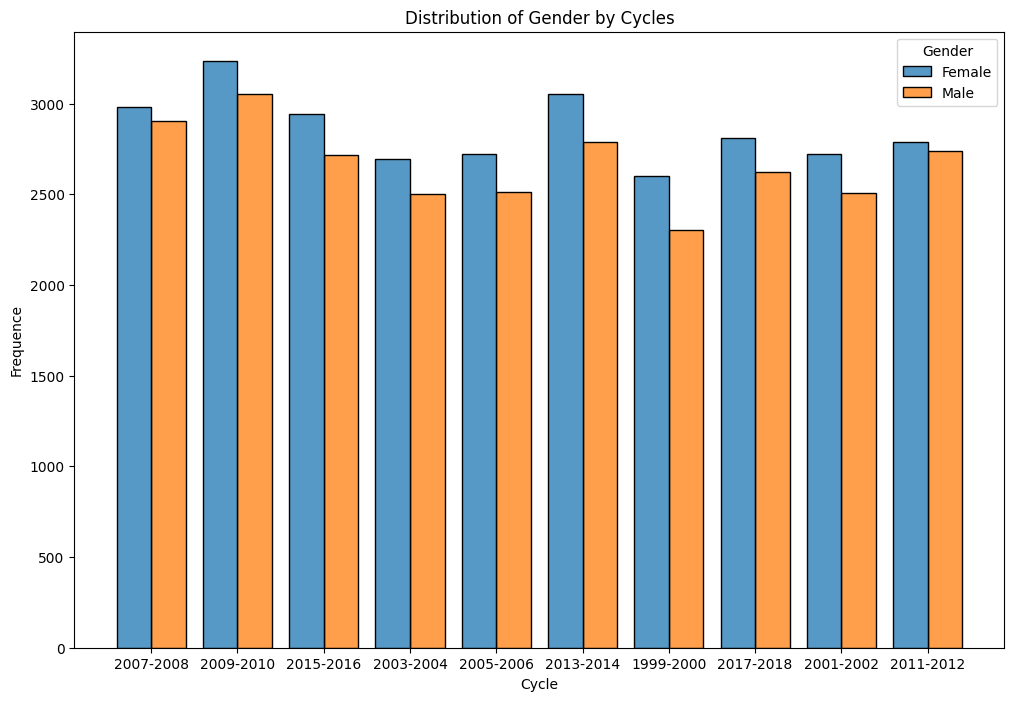

In [142]:
# QC in GENDER
df_nhanes_gt['Gender'] = df_nhanes_gt['RIAGENDR'].map({1: 'Male', 2: 'Female'})

print("Gender distribution")
print(df_nhanes_gt["Gender"].describe())

plt.figure(figsize=(12, 8))
sns.histplot(data=df_nhanes_gt, x='Cycle', hue='Gender', multiple='dodge', shrink=0.8)
plt.title('Distribution of Gender by Cycles')
plt.xlabel('Cycle')
plt.ylabel('Frequence')
plt.show()

### Understanding Body Mass Index (BMI)

Body Mass Index (BMI) is a measure of body fat based on height and weight that applies to adult men and women. It is calculated by dividing a person's weight in kilograms by the square of their height in meters. BMI is used as a screening tool to categorize individuals into different weight categories, which can help identify potential health risks.

#### Recommended Levels of BMI

BMI is measured in kilograms per square meter (kg/m²). Here are the general guidelines for BMI levels:

- **Underweight**: Less than 18.5 kg/m²
  - A BMI in this range indicates that a person may be underweight, which could pose health risks such as nutritional deficiencies and weakened immune function.
- **Normal weight**: 18.5-24.9 kg/m²
  - This range is considered healthy and is associated with a lower risk of chronic diseases related to weight.
- **Overweight**: 25-29.9 kg/m²
  - Individuals in this range are considered overweight, which can increase the risk of cardiovascular diseases, diabetes, and other health conditions.
- **Obesity**: 30 kg/m² and above
  - A BMI of 30 or higher is classified as obesity. This significantly increases the risk of various health issues, including heart disease, diabetes, hypertension, and certain cancers.

Maintaining a healthy BMI is crucial for overall health and well-being. Regular check-ups and a balanced diet combined with physical activity are important for managing BMI and reducing health risks.

#### BMI Histogram

Below is a histogram representing the distribution of BMI levels in the study population:


BMI distribution
count    55206.000000
mean        28.720216
std          6.833904
min         12.040000
25%         23.970000
50%         27.600000
75%         32.100000
max        130.210000
Name: BMXBMI, dtype: float64


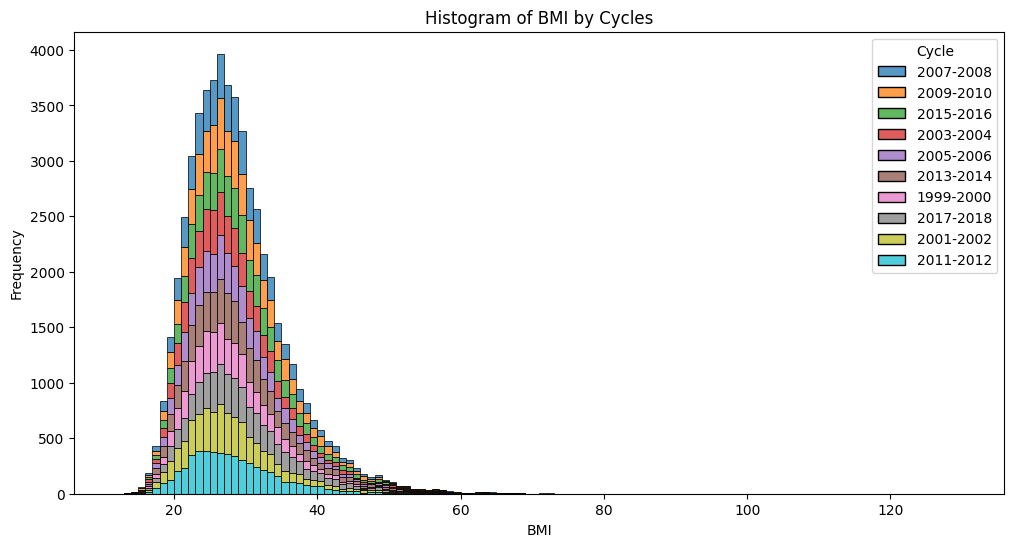

In [143]:
print("BMI distribution")
print(df_nhanes_gt['BMXBMI'].describe())
#  distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df_nhanes_gt, x='BMXBMI', hue='Cycle', multiple='stack', bins=range(int(df_nhanes_gt['BMXBMI'].min()), int(df_nhanes_gt['BMXBMI'].max()) + 1), edgecolor='black')
plt.title('Histogram of BMI by Cycles')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

count                  59204
unique                     5
top       Non-Hispanic White
freq                   25420
Name: Race/Ethnicity, dtype: object


/var/folders/06/f05rc_9x21nfs2142bf0fmcr0000gn/T/ipykernel_46593/3006124433.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nhanes_gt['Race/Ethnicity'] = df_nhanes_gt['RIDRETH1'].map(race_ethnicity_mapping)


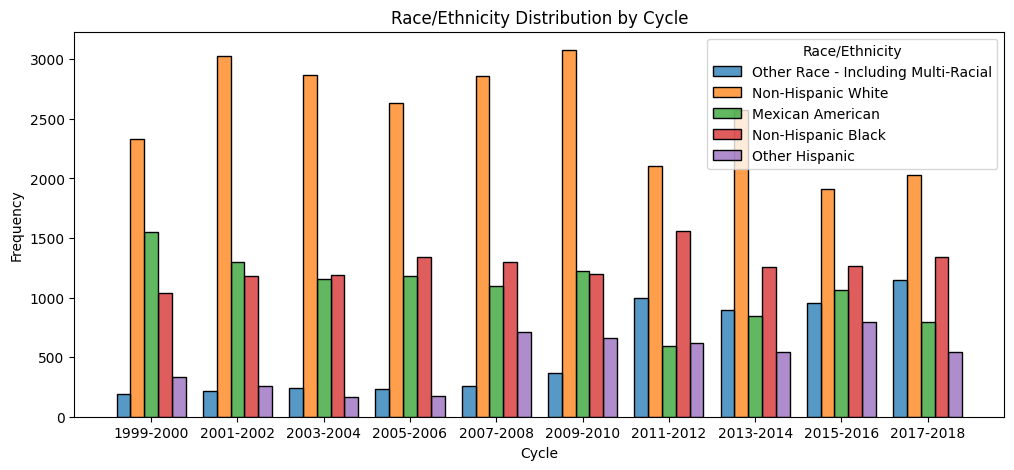

In [117]:
# RIDRETH1,Race/Ethnicity - Recode
# print(df_nhanes_gt['RIDRETH1'].unique())
race_ethnicity_mapping = {
    1: 'Mexican American',
    2: 'Other Hispanic',
    3: 'Non-Hispanic White',
    4: 'Non-Hispanic Black',
    5: 'Other Race - Including Multi-Racial'
}

df_nhanes_gt['Race/Ethnicity'] = df_nhanes_gt['RIDRETH1'].map(race_ethnicity_mapping)

print(df_nhanes_gt['Race/Ethnicity'].describe())

plt.figure(figsize=(12, 5))
sns.histplot(data=df_nhanes_gt, x='Cycle', hue='Race/Ethnicity', multiple='dodge', shrink=0.8)
plt.title('Race/Ethnicity Distribution by Cycle')
plt.xlabel('Cycle')
plt.ylabel('Frequency')
plt.show()

# Show stacked bar chart
# plt.figure(figsize=(12, 5))
# sns.histplot(data=df_nhanes_gt, x='Cycle', hue='Race/Ethnicity', multiple='stack')
# plt.title('Race/ethnicity distribution by cumulative cycle')
# plt.xlabel('Cycle')
# plt.ylabel('Frequency')
# plt.show()

## Phenotypes

### HDL Cholesterol

High-Density Lipoprotein (HDL) cholesterol is known as "good" cholesterol because it helps remove other forms of cholesterol from your bloodstream. HDL carries cholesterol away from the arteries and back to the liver, where it is processed and removed from the body. High levels of HDL cholesterol can reduce the risk of heart disease and stroke.

#### Recommended Levels of HDL Cholesterol

HDL cholesterol levels are measured in milligrams per deciliter (mg/dL) of blood. Here are the general guidelines for HDL cholesterol levels:

- **Low**: Less than 40 mg/dL for men and less than 50 mg/dL for women
  - Low HDL levels are considered a risk factor for heart disease.
- **Normal**: 40-59 mg/dL for men and 50-59 mg/dL for women
  - Levels in this range are generally acceptable, but higher levels are better.
- **High**: 60 mg/dL and above
  - High HDL levels are considered protective against heart disease and are a sign of good cardiovascular health.

Maintaining healthy levels of HDL cholesterol is important for overall cardiovascular health. Regular check-ups and blood tests are important for monitoring HDL cholesterol levels and taking appropriate action if levels are low.

#### HDL Cholesterol Histogram

Below is a histogram representing the distribution of HDL cholesterol levels in the study population:


Cycles 1999-2000 to 2001-2002 [LBDHDL - HDL-cholesterol (mg/dL)]
count    24525.000000
mean       113.964485
std         35.930012
min          9.000000
25%         89.000000
50%        111.000000
75%        136.000000
max        629.000000
Name: LBDLDL, dtype: float64


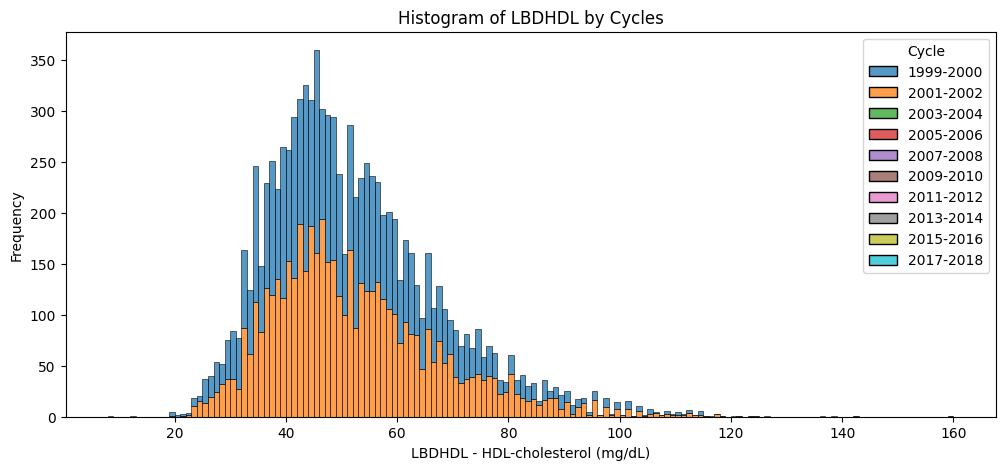

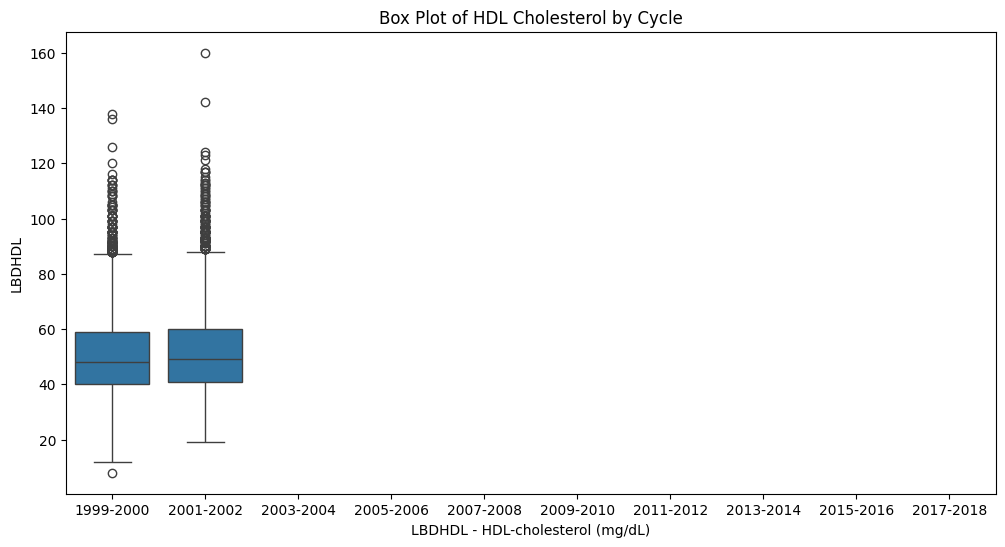

In [124]:
# LBDHDL,HDL-cholesterol (mg/dL)
print("Cycles 1999-2000 to 2001-2002 [LBDHDL - HDL-cholesterol (mg/dL)]")
print(df_nhanes_gt['LBDLDL'].describe())
plt.figure(figsize=(12, 5))
sns.histplot(data=df_nhanes_gt, x='LBDHDL', hue='Cycle', multiple='stack', bins=range(int(df_nhanes_gt['LBDHDL'].min()), int(df_nhanes_gt['LBDHDL'].max()) + 1), edgecolor='black')
plt.title('Histogram of LBDHDL by Cycles')
plt.xlabel('LBDHDL - HDL-cholesterol (mg/dL)')
plt.ylabel('Frequency')
plt.show()

# boxplot of HDL by cycle
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_nhanes_gt, x='Cycle', y='LBDHDL', order=cycle_order)
plt.title('Box Plot of HDL Cholesterol by Cycle')
plt.xlabel('Cycle')
plt.xlabel('LBDHDL - HDL-cholesterol (mg/dL)')
plt.show()

Cycle 2003-2004 [LBXHDD - Direct HDL-Cholesterol (mg/dL)]
count    4990.000000
mean       54.560922
std        16.041131
min        19.000000
25%        43.000000
50%        52.000000
75%        64.000000
max       154.000000
Name: LBXHDD, dtype: float64


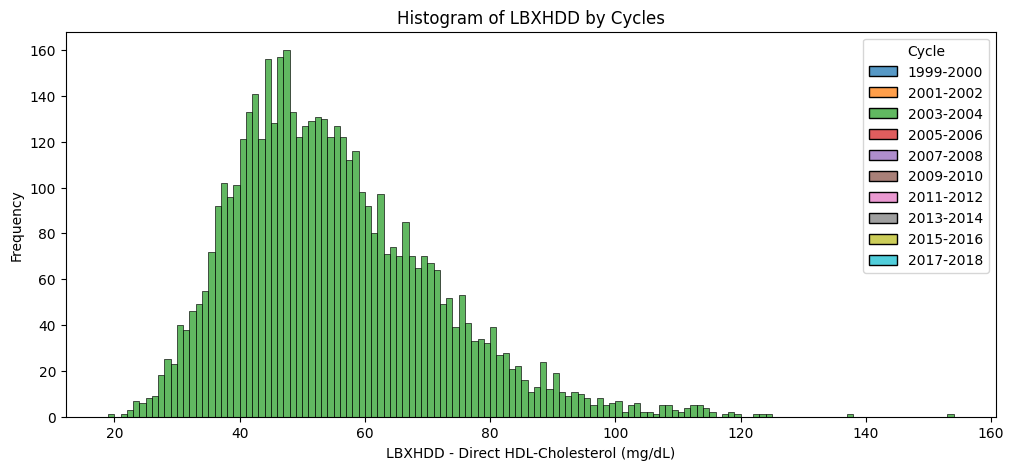

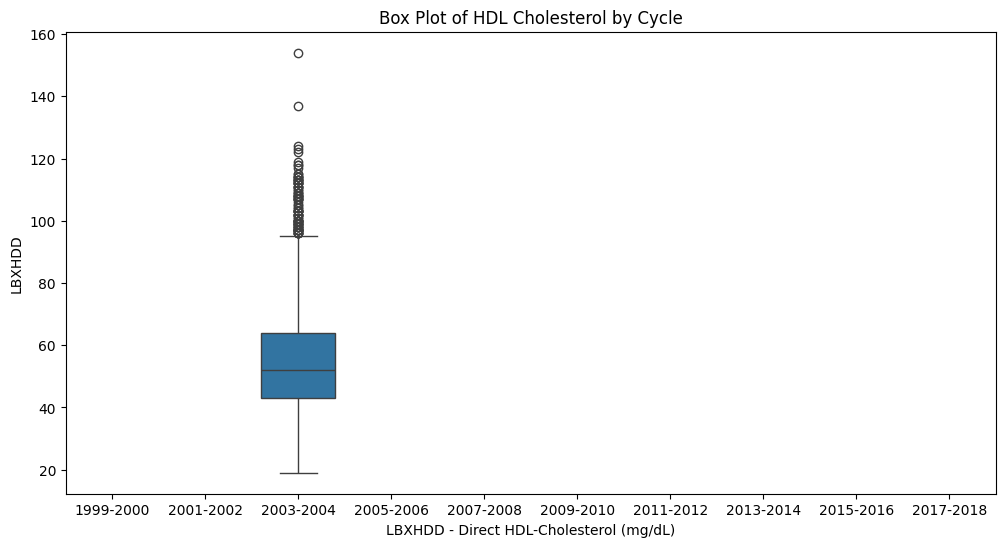

In [123]:
# LBXHDD,Direct HDL-Cholesterol (mg/dL)
print("Cycle 2003-2004 [LBXHDD - Direct HDL-Cholesterol (mg/dL)]")
print(df_nhanes_gt['LBXHDD'].describe())
plt.figure(figsize=(12, 5))
sns.histplot(data=df_nhanes_gt, x='LBXHDD', hue='Cycle', multiple='stack', bins=range(int(df_nhanes_gt['LBXHDD'].min()), int(df_nhanes_gt['LBXHDD'].max()) + 1), edgecolor='black')
plt.title('Histogram of LBXHDD by Cycles')
plt.xlabel('LBXHDD - Direct HDL-Cholesterol (mg/dL)')
plt.ylabel('Frequency')

# boxplot of HDL by cycle
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_nhanes_gt, x='Cycle', y='LBXHDD', order=cycle_order)
plt.title('Box Plot of HDL Cholesterol by Cycle')
plt.xlabel('Cycle')
plt.xlabel('LBXHDD - Direct HDL-Cholesterol (mg/dL)')
plt.show()

Cycled 2005-2006 to 2017-2018 [LBDHDD - Direct HDL-Cholesterol (mg/dL)]
count    37952.000000
mean        53.085819
std         16.088424
min          6.000000
25%         42.000000
50%         51.000000
75%         62.000000
max        226.000000
Name: LBDHDD, dtype: float64


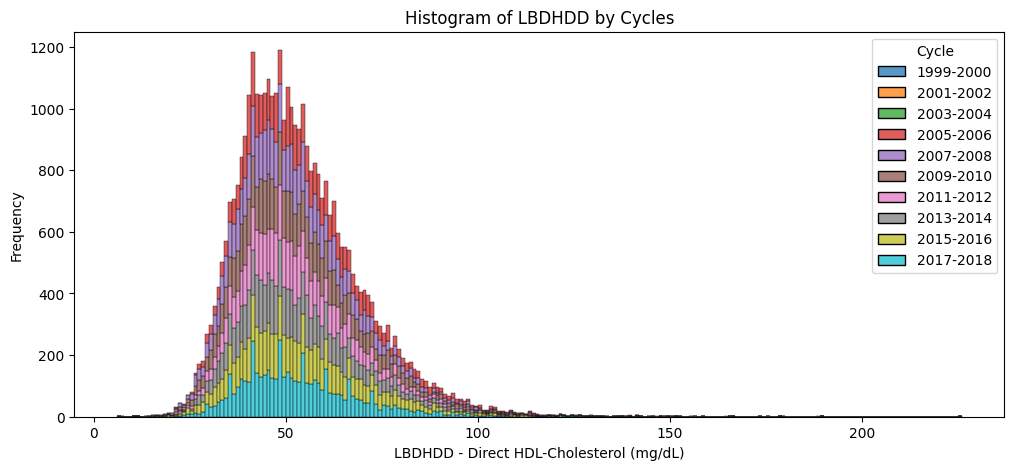

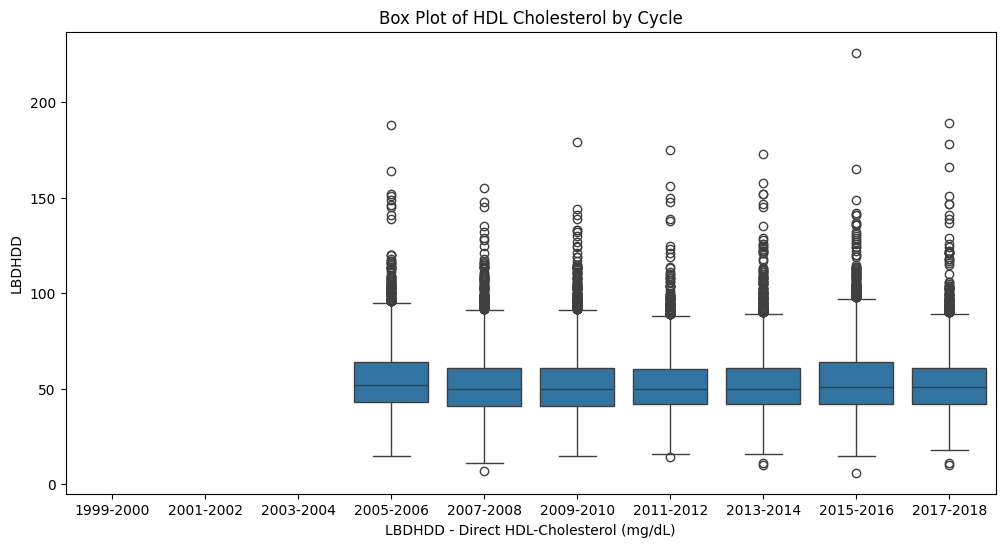

In [122]:
# LBDHDD,Direct HDL-Cholesterol (mg/dL)
print("Cycled 2005-2006 to 2017-2018 [LBDHDD - Direct HDL-Cholesterol (mg/dL)]")
print(df_nhanes_gt['LBDHDD'].describe())
plt.figure(figsize=(12, 5))
sns.histplot(data=df_nhanes_gt, x='LBDHDD', hue='Cycle', multiple='stack', bins=range(int(df_nhanes_gt['LBDHDD'].min()), int(df_nhanes_gt['LBDHDD'].max()) + 1), edgecolor='black')
plt.title('Histogram of LBDHDD by Cycles')
plt.xlabel('LBDHDD - Direct HDL-Cholesterol (mg/dL)')
plt.ylabel('Frequency')
plt.show()

# boxplot of HDL by cycle
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_nhanes_gt, x='Cycle', y='LBDHDD', order=cycle_order)
plt.title('Box Plot of HDL Cholesterol by Cycle')
plt.xlabel('Cycle')
plt.xlabel('LBDHDD - Direct HDL-Cholesterol (mg/dL)')
plt.show()

### LDL Cholesterol

Low-Density Lipoprotein (LDL) cholesterol is often referred to as "bad" cholesterol because high levels can lead to the buildup of cholesterol in your arteries. This can increase the risk of heart disease and stroke. LDL carries cholesterol from the liver to the cells, but if there is too much LDL cholesterol in the blood, it can deposit on the walls of the arteries, forming plaques that can narrow and harden the arteries.

#### Recommended Levels of LDL Cholesterol

LDL cholesterol levels are measured in milligrams per deciliter (mg/dL) of blood. Here are the general guidelines for LDL cholesterol levels:

- **Optimal**: Less than 100 mg/dL
  - This level is considered healthy and associated with a lower risk of heart disease.
- **Near Optimal/Above Optimal**: 100-129 mg/dL
  - Levels in this range are acceptable for most people, but lower levels are better for those at risk of heart disease.
- **Borderline High**: 130-159 mg/dL
  - Levels in this range indicate an increased risk of heart disease. Lifestyle changes may be recommended to lower LDL cholesterol.
- **High**: 160-189 mg/dL
  - Levels of 160-189 mg/dL are associated with a higher risk of heart disease. Medical intervention and lifestyle changes are often necessary to reduce LDL cholesterol.
- **Very High**: 190 mg/dL and above
  - Levels of 190 mg/dL or higher significantly increase the risk of heart disease. Immediate medical intervention is required.

Maintaining healthy levels of LDL cholesterol is crucial for cardiovascular health. Regular check-ups and blood tests are important for monitoring LDL cholesterol levels and taking appropriate action if levels are high.

#### LDL Cholesterol Histogram

Below is a histogram representing the distribution of LDL cholesterol levels in the study population:


Description of LDL Cholesterol
count    24525.000000
mean       113.964485
std         35.930012
min          9.000000
25%         89.000000
50%        111.000000
75%        136.000000
max        629.000000
Name: LBDLDL, dtype: float64


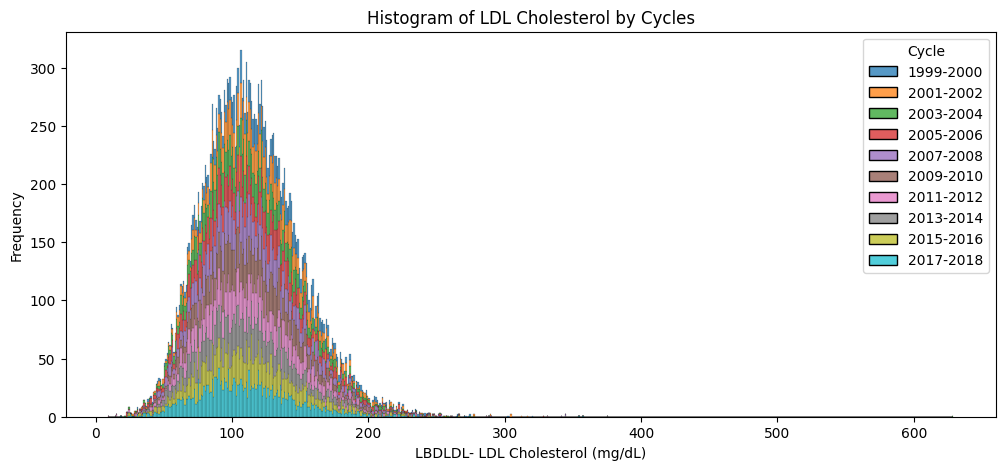

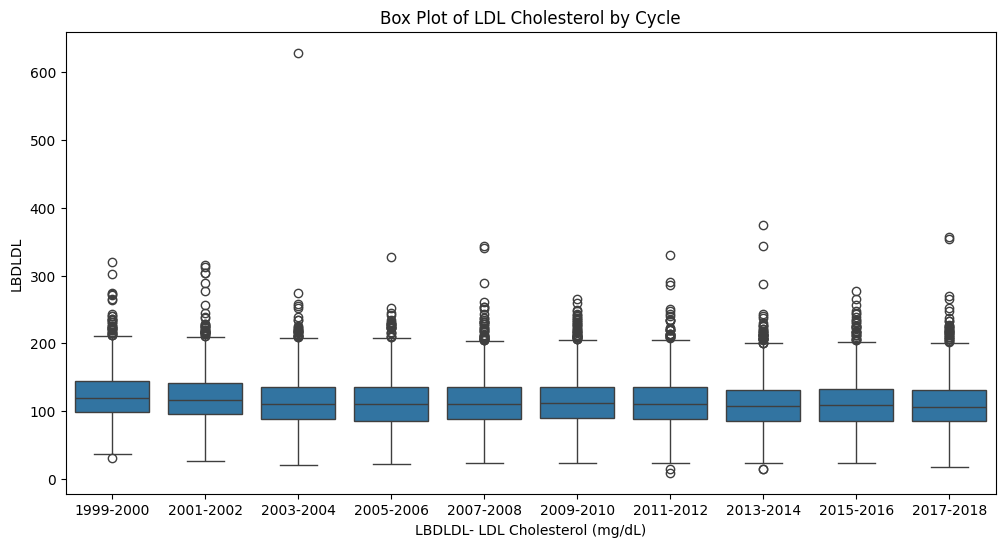

In [121]:
print("Description of LDL Cholesterol")
print(df_nhanes_gt['LBDLDL'].describe())

# LBDLDL,LDL-cholesterol (mg/dL)
plt.figure(figsize=(12, 5))
sns.histplot(data=df_nhanes_gt, x='LBDLDL', hue='Cycle', multiple='stack', bins=range(int(df_nhanes_gt['LBDLDL'].min()), int(df_nhanes_gt['LBDLDL'].max()) + 1), edgecolor='black')
plt.title('Histogram of LDL Cholesterol by Cycles')
plt.xlabel('LBDLDL- LDL Cholesterol (mg/dL)')
plt.ylabel('Frequency')
plt.show()

# boxplot of LDL by cycle
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_nhanes_gt, x='Cycle', y='LBDLDL', order=cycle_order)
plt.title('Box Plot of LDL Cholesterol by Cycle')
plt.xlabel('Cycle')
plt.xlabel('LBDLDL- LDL Cholesterol (mg/dL)')
plt.show()

# plt.figure(figsize=(12, 5))
# sns.histplot(data=df_nhanes_gt, x='LBDLDL', kde=True, bins=30, edgecolor='black')
# plt.title('Histogram of LDL Cholesterol')
# plt.xlabel('LBDLDL- LDL Cholesterol (mg/dL)')
# plt.ylabel('Frequency')
# plt.show()


### Total Cholesterol

Total cholesterol is a measure of the overall amount of cholesterol in your blood. It includes the following components:

- **Low-Density Lipoprotein (LDL) Cholesterol**: Often referred to as "bad" cholesterol, LDL can build up on the walls of your arteries and increase your risk of heart disease and stroke.
- **High-Density Lipoprotein (HDL) Cholesterol**: Known as "good" cholesterol, HDL helps remove LDL cholesterol from the arteries.
- **Very Low-Density Lipoprotein (VLDL) Cholesterol**: Contains the highest amount of triglycerides, which are a type of fat carried in the blood.

#### Recommended Levels of Total Cholesterol

Total cholesterol levels are measured in milligrams per deciliter (mg/dL) of blood. Here are the general guidelines for total cholesterol levels:

- **Desirable**: Less than 200 mg/dL
  - This level is considered healthy and associated with a lower risk of heart disease.
- **Borderline High**: 200-239 mg/dL
  - Levels in this range indicate an increased risk of heart disease. Lifestyle changes may be recommended to lower cholesterol.
- **High**: 240 mg/dL and above
  - Levels of 240 mg/dL or higher are associated with a higher risk of heart disease. Medical intervention and lifestyle changes are often necessary to reduce cholesterol.

Maintaining healthy levels of total cholesterol is crucial for cardiovascular health. Regular check-ups and blood tests are important for monitoring cholesterol levels and taking appropriate action if levels are high.

#### Total Cholesterol Histogram

Below is a histogram representing the distribution of total cholesterol levels in the study population:


Description of Total Cholesterol
count    52767.000000
mean       193.910417
std         42.778127
min         59.000000
25%        164.000000
50%        190.000000
75%        220.000000
max        813.000000
Name: LBXTC, dtype: float64


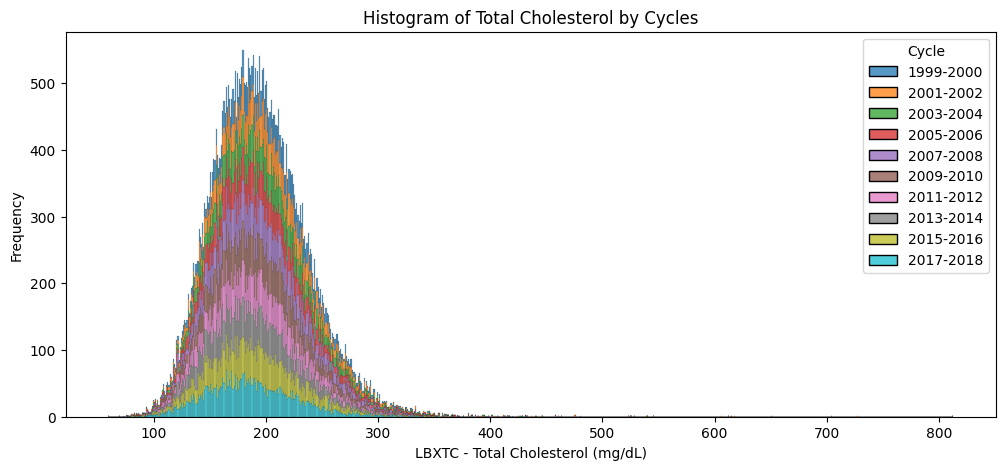

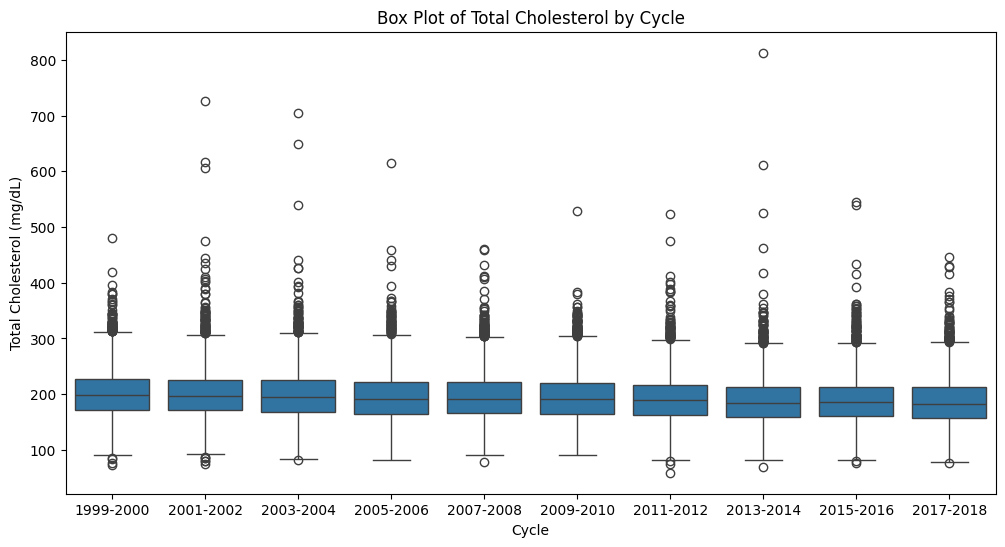

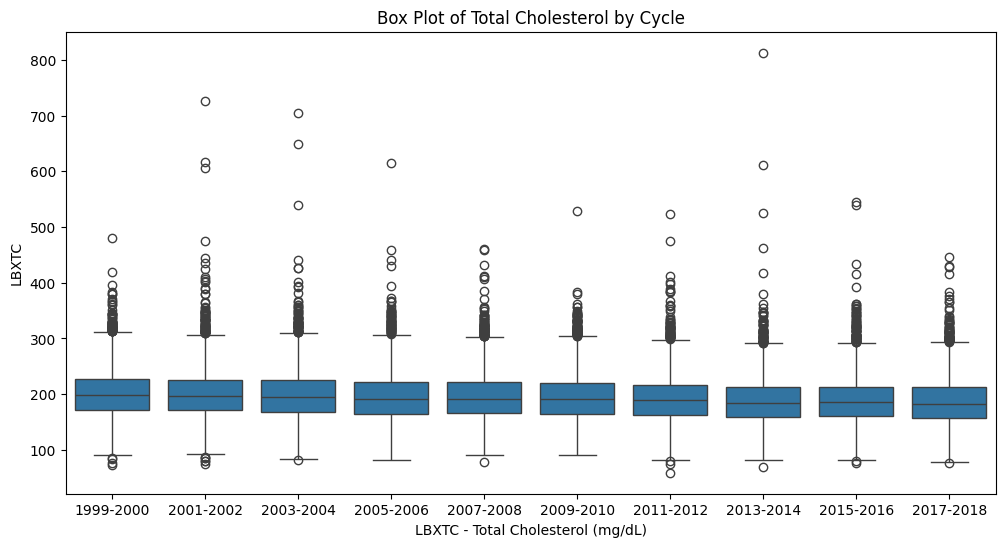

In [120]:
print("Description of Total Cholesterol")
print(df_nhanes_gt['LBXTC'].describe())

# Plotting the histogram of total cholesterol by cycles
plt.figure(figsize=(12, 5))
sns.histplot(data=df_nhanes_gt, x='LBXTC', hue='Cycle', multiple='stack', bins=range(int(df_nhanes_gt['LBXTC'].min()), int(df_nhanes_gt['LBXTC'].max()) + 1), edgecolor='black')
plt.title('Histogram of Total Cholesterol by Cycles')
plt.xlabel('LBXTC - Total Cholesterol (mg/dL)')
plt.ylabel('Frequency')
plt.show()

# boxplot of total cholesterol by cycle
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_nhanes_gt, x='Cycle', y='LBXTC', order=cycle_order)
plt.title('Box Plot of Total Cholesterol by Cycle')
plt.xlabel('Cycle')
plt.ylabel('Total Cholesterol (mg/dL)')
plt.show()

# boxplot of triglycerides by cycle
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_nhanes_gt, x='Cycle', y='LBXTC', order=cycle_order)
plt.title('Box Plot of Total Cholesterol by Cycle')
plt.xlabel('Cycle')
plt.xlabel('LBXTC - Total Cholesterol (mg/dL)')
plt.show()

### Triglycerides

Triglycerides are a type of fat (lipid) found in your blood. When you eat, your body converts any calories it doesn't need to use right away into triglycerides. These triglycerides are stored in your fat cells and later released by hormones for energy between meals. High levels of triglycerides can increase your risk of heart disease and may be a sign of metabolic syndrome, a combination of high blood pressure, high blood sugar, excess body fat around the waist, and abnormal cholesterol levels.

#### Recommended Levels of Triglycerides

Triglyceride levels are measured in milligrams per deciliter (mg/dL) of blood. Here are the general guidelines for triglyceride levels:

- **Normal**: Less than 150 mg/dL
  - This level is considered healthy and associated with a lower risk of heart disease.
- **Borderline High**: 150-199 mg/dL
  - Levels in this range indicate an increased risk of heart disease. Lifestyle changes may be recommended to lower triglycerides.
- **High**: 200-499 mg/dL
  - Levels of 200-499 mg/dL are associated with a higher risk of heart disease. Medical intervention and lifestyle changes are often necessary to reduce triglycerides.
- **Very High**: 500 mg/dL and above
  - Levels of 500 mg/dL or higher significantly increase the risk of pancreatitis in addition to heart disease. Immediate medical intervention is required.

Maintaining healthy levels of triglycerides is crucial for overall cardiovascular health. Regular check-ups and blood tests are important for monitoring triglyceride levels and taking appropriate action if levels are high.

#### Triglycerides Histogram

Below is a histogram representing the distribution of triglyceride levels in the study population:

Description of Total Cholesterol
count    47038.000000
mean       147.061652
std        128.692426
min          9.000000
25%         77.000000
50%        116.000000
75%        177.000000
max       6057.000000
Name: LBXSTR, dtype: float64


/Users/andrerico/Works/Projects/pbs_igem/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


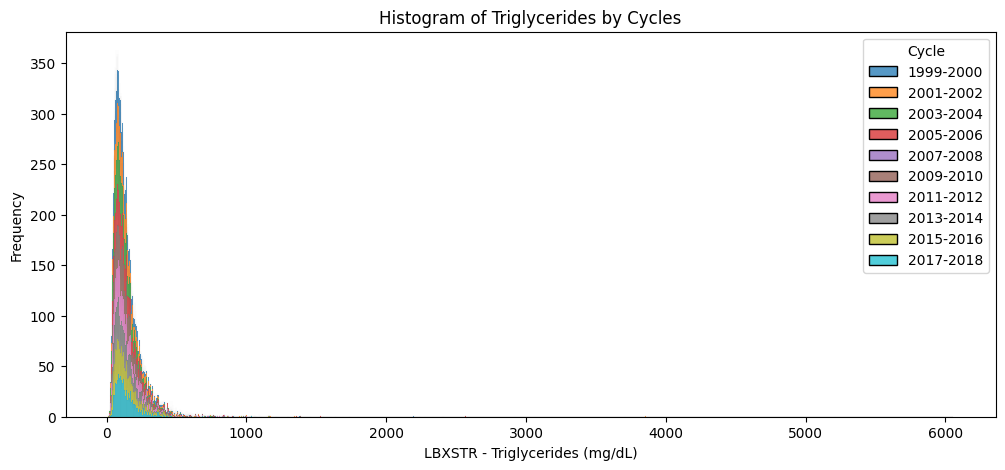

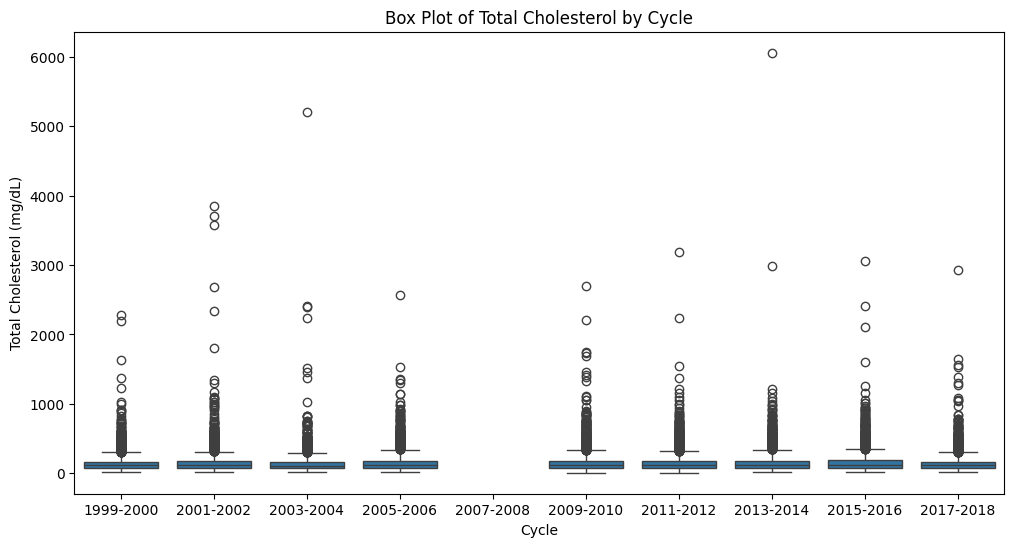

In [119]:
print("Description of Triglycerides")
print(df_nhanes_gt['LBXSTR'].describe())

# Plotting the histogram of Triglycerides by cycles
plt.figure(figsize=(12, 5))
sns.histplot(data=df_nhanes_gt, x='LBXSTR', hue='Cycle', multiple='stack', bins=range(int(df_nhanes_gt['LBXSTR'].min()), int(df_nhanes_gt['LBXSTR'].max()) + 1), edgecolor='black')
plt.title('Histogram of Triglycerides by Cycles')
plt.xlabel('LBXSTR - Triglycerides (mg/dL)')
plt.ylabel('Frequency')
plt.show()

# boxplot of triglycerides by cycle
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_nhanes_gt, x='Cycle', y='LBXSTR', order=cycle_order)
plt.title('Box Plot of Triglycerides by Cycle')
plt.xlabel('Cycle')
plt.ylabel('LBXSTR - Triglycerides (mg/dL)')
plt.show()

# # Plotting the histogram of Triglycerides
# plt.figure(figsize=(12, 5))
# sns.histplot(data=df_nhanes_gt, x='LBXSTR', kde=True, bins=30, edgecolor='black')
# plt.title('Histogram of Triglycerides')
# plt.xlabel('LBXSTR - Triglycerides (mg/dL)')
# plt.ylabel('Frequency')
# plt.show()

In [154]:
df_nhanes_gt.to_csv(str(path_data) + "/step_03_01_nhanes_data.csv", index=False)

STOP THIS PHASE HERE.....

In [145]:
# Função para categorizar colunas automaticamente
def categorize_columns(df):
    continuous = []
    categorical = []
    binary = []
    
    for col in df.columns:
        unique_values = df[col].dropna().unique()  # Valores únicos não nulos
        num_unique_values = len(unique_values)
        
        if pd.api.types.is_numeric_dtype(df[col]):
            if num_unique_values == 2:
                binary.append(col)
            else:
                continuous.append(col)
        else:
            if num_unique_values == 2:
                binary.append(col)
            else:
                categorical.append(col)
    
    return continuous, categorical, binary

# Executa a função para categorizar as colunas
continuous_cols, categorical_cols, binary_cols = categorize_columns(df_nhanes_gt)

# Exibe os resultados
print(f"Continuous columns: {continuous_cols}")
print(f"Categorical columns: {categorical_cols}")
print(f"Binary columns: {binary_cols}")

# Ajusta os tipos de colunas no DataFrame
for col in continuous_cols:
    df_nhanes_gt[col] = df_nhanes_gt[col].astype(float)

for col in categorical_cols:
    df_nhanes_gt[col] = df_nhanes_gt[col].astype('category')

for col in binary_cols:
    df_nhanes_gt[col] = df_nhanes_gt[col].astype('category')  # Pode usar boolean se preferir

Continuous columns: ['sample', 'sequence', 'ALQ140Q', 'ALQ150', 'AUQ231', 'BMXBMI', 'CBD620', 'CBQ050', 'DBD060', 'DBD072A', 'DBD072B', 'DBD072C', 'DBD072D', 'DBD072U', 'DBD222B', 'DBD222C', 'DBD222D', 'DBD222U', 'DBQ197', 'DBQ229', 'DBQ235A', 'DBQ235B', 'DBQ235C', 'DBQ925B', 'DUQ250', 'DUQ260', 'DUQ270Q', 'DUQ272', 'DUQ290', 'DUQ300', 'DUQ310Q', 'DUQ330', 'DUQ340', 'DUQ350Q', 'DUQ352', 'DUQ380A', 'DUQ380B', 'DUQ380C', 'DUQ380D', 'ECQ030', 'ECQ040', 'ENQ090', 'GTDSCMMN', 'GTXDRANK', 'HOQ070', 'HOQ080', 'HSQ590', 'LBD4CELC', 'LBDFOL', 'LBDHDD', 'LBDIHGSI', 'LBDLDL', 'LBDRBF', 'LBDV1ALC', 'LBDV1ELC', 'LBDV2CLC', 'LBDV2ELC', 'LBDV2PLC', 'LBDV4CLC', 'LBDVBFLC', 'LBDVCFLC', 'LBDVDBLC', 'LBDVDELC', 'LBDVEBLC', 'LBDVMELC', 'LBDVOXLC', 'LBDVSTLC', 'LBDVTCLC', 'LBDVTOLC', 'LBDVTPLC', 'LBDVXYLC', 'LBDWBFLC', 'LBDWCFLC', 'LBX2DF', 'LBXBCD', 'LBXBPB', 'LBXCOT', 'LBXIHG', 'LBXNM', 'LBXPFBS', 'LBXPFDE', 'LBXPFDO', 'LBXPFOA', 'LBXPFOS', 'LBXPFSA', 'LBXPFUA', 'LBXPLP', 'LBXRBFSI', 'LBXSF2SI', 'LBXTC',

In [147]:
df_nhanes_gt.dtypes

Cycle       category
sample       float64
sequence     float64
ALQ140Q      float64
ALQ150       float64
              ...   
SSXUP8       float64
URDMETLC    category
URXMET       float64
WTUIO2YR     float64
Gender      category
Length: 917, dtype: object

## Split Cohorts

good = HDL - Have 3 diff types of metrics ()

bad = LDL, Total-C and Triglycerides split in Discovery (1999-2008) and Replicate (2009-2018)

In [152]:
# Slipt the data into discovery and replicate in bad group 
cycles_discovery = ['1999-2000', '2001-2002', '2003-2004', '2005-2006', '2007-2008']
cycles_replicate = ['2009-2010', '2011-2012', '2013-2014', '2015-2016', '2017-2018']

df_nhanes_discovery = df_nhanes_gt[df_nhanes_gt['Cycle'].isin(cycles_discovery)]
df_nhanes_replicate = df_nhanes_gt[df_nhanes_gt['Cycle'].isin(cycles_replicate)]

df_nhanes_discovery['Cycle'] = pd.Categorical(df_nhanes_discovery['Cycle'], categories=cycles_discovery, ordered=True)
df_nhanes_replicate['Cycle'] = pd.Categorical(df_nhanes_replicate['Cycle'], categories=cycles_replicate, ordered=True)

print(df_nhanes_discovery['Cycle'].unique)
print(df_nhanes_replicate['Cycle'].unique)

<bound method Series.unique of 0         2007-2008
2         2007-2008
4         2007-2008
6         2007-2008
7         2007-2008
            ...    
387166    2001-2002
387167    2001-2002
387171    2001-2002
387175    2001-2002
387186    2001-2002
Name: Cycle, Length: 26452, dtype: category
Categories (5, object): ['1999-2000' < '2001-2002' < '2003-2004' < '2005-2006' < '2007-2008']>
<bound method Series.unique of 10149     2009-2010
10153     2009-2010
10154     2009-2010
10155     2009-2010
10158     2009-2010
            ...    
396935    2011-2012
396937    2011-2012
396938    2011-2012
396939    2011-2012
396941    2011-2012
Name: Cycle, Length: 28754, dtype: category
Categories (5, object): ['2009-2010' < '2011-2012' < '2013-2014' < '2015-2016' < '2017-2018']>


/var/folders/06/f05rc_9x21nfs2142bf0fmcr0000gn/T/ipykernel_46593/592895914.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nhanes_discovery['Cycle'] = pd.Categorical(df_nhanes_discovery['Cycle'], categories=cycles_discovery, ordered=True)
/var/folders/06/f05rc_9x21nfs2142bf0fmcr0000gn/T/ipykernel_46593/592895914.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nhanes_replicate['Cycle'] = pd.Categorical(df_nhanes_replicate['Cycle'], categories=cycles_replicate, ordered=True)
